In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter

In [2]:
# Path definitions
run_dir = "/config/workspace/team_workspace/users/Kari/data/run_20250509_221252_classical"
query_csv = "/config/workspace/team_workspace/users/Kari/data/antique_train_queries.csv"
docs_csv = "/config/workspace/team_workspace/users/Kari/data/antique_doc_embeddings.csv"

In [3]:
# Load data
cluster_mapping = pd.read_csv(os.path.join(run_dir, "doc_clusters.csv"))
query_df = pd.read_csv(query_csv)
correspondence = pd.read_csv(os.path.join(run_dir, "cluster_correspondence.csv"))

In [4]:
# Load embeddings if needed for analysis
try:
    doc_embeddings_reduced = np.load(os.path.join(run_dir, "doc_embeddings_reduced.npy"))
    refined_medoid_indices = np.load(os.path.join(run_dir, "refined_medoid_indices.npy"))
    refined_medoid_embeddings = np.load(os.path.join(run_dir, "refined_medoid_embeddings.npy"))
except:
    print("Note: Embedding files not loaded")

print("=== Original Dataset EDA (Ground Truth) ===")

=== Original Dataset EDA (Ground Truth) ===


In [5]:
# 1. Basic statistics about queries and relevance scores
print(f"Total queries: {query_df['query_id'].nunique()}")
print(f"Total query-document pairs: {len(query_df)}")

Total queries: 50
Total query-document pairs: 1651


In [6]:
# Document counts per query
docs_per_query = query_df["query_id"].value_counts()
relevant_docs_per_query = query_df[query_df['relevance'] > 0].groupby('query_id')['doc_id'].count()

print("\nDocument statistics per query:")
print(f"Avg documents per query: {docs_per_query.mean():.2f}")
print(f"Min documents per query: {docs_per_query.min()}")
print(f"Max documents per query: {docs_per_query.max()}")
print(f"Avg relevant documents per query: {relevant_docs_per_query.mean():.2f}")


Document statistics per query:
Avg documents per query: 33.02
Min documents per query: 12
Max documents per query: 64
Avg relevant documents per query: 33.02


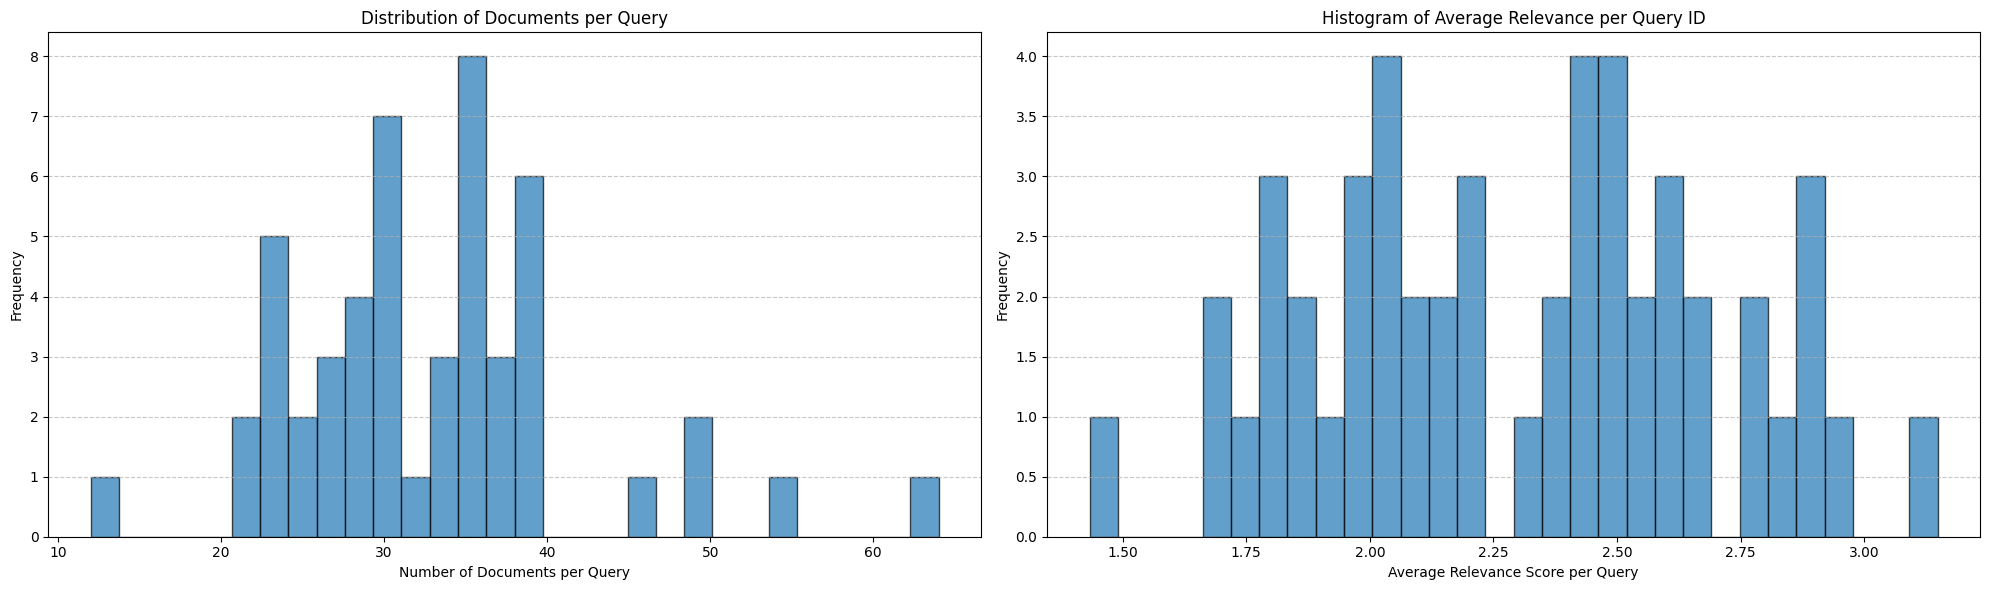

In [7]:
# 2. Visualize query document distribution
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # Changed to 1 row, 2 columns

# All documents per query
axes[0].hist(docs_per_query, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Number of Documents per Query")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Documents per Query")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Average relevance per query
avg_relevance_per_query = query_df.groupby("query_id")["relevance"].mean()
axes[1].hist(avg_relevance_per_query, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Average Relevance Score per Query")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Average Relevance per Query ID")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

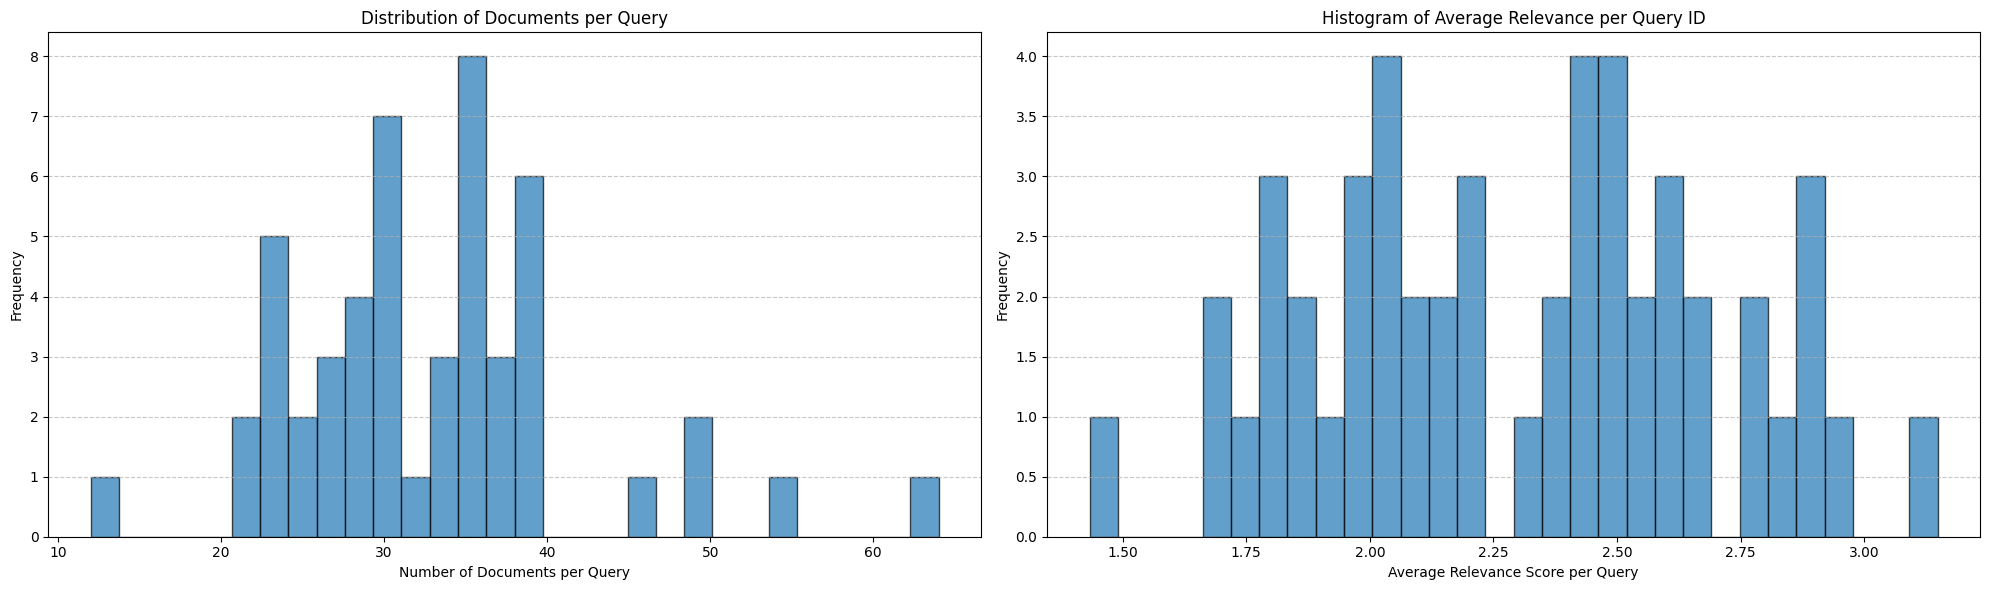


Document Distribution per Query - Summary Statistics:


,Documents per Query
count,50.000000
mean,33.020000
std,8.968175
min,12.000000
25%,27.250000
50%,32.500000
75%,37.000000
max,64.000000



Document Distribution per Query - By Range:


,Range,Number of Queries,Percentage
0,0-10,0,0.0
1,11-20,1,2.0
2,21-30,20,40.0
3,31-40,24,48.0
4,41-50,3,6.0
5,51-100,2,4.0
6,101-∞,0,0.0



Average Relevance per Query - Summary Statistics:


,Average Relevance per Query
count,50.000000
mean,2.300328
std,0.392730
min,1.433333
25%,2.006944
50%,2.339713
75%,2.574219
max,3.148148



Average Relevance per Query - By Range:


,Range,Number of Queries,Percentage
0,0.0-0.5,0,0.0
1,0.5-1.0,0,0.0
2,1.0-1.5,1,2.0
3,1.5-2.0,12,24.0
4,2.0-2.5,21,42.0
5,2.5-3.0,15,30.0
6,3.0-∞,1,2.0



Sample Queries with Most Documents:


,query_id,total_docs,relevant_docs,avg_relevance
0,4372730,64,64,2.546875
1,2382487,55,55,2.672727
2,3385681,50,50,2.220000
3,1944018,49,49,2.387755
4,788976,45,45,2.466667



Sample Queries with Highest Average Relevance:


,query_id,total_docs,relevant_docs,avg_relevance
0,2582920,27,27,3.148148
1,1199639,39,39,2.974359
2,2446614,34,34,2.911765
3,3396066,35,35,2.885714
4,1015624,22,22,2.863636


In [8]:
# 2. Visualize query document distribution
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# All documents per query
axes[0].hist(docs_per_query, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Number of Documents per Query")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Documents per Query")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Average relevance per query
avg_relevance_per_query = query_df.groupby("query_id")["relevance"].mean()
axes[1].hist(avg_relevance_per_query, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Average Relevance Score per Query")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Average Relevance per Query ID")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# 2a. Create and display summary tables for the two distributions
print("\nDocument Distribution per Query - Summary Statistics:")
docs_per_query_summary = docs_per_query.describe().to_frame()
docs_per_query_summary.columns = ['Documents per Query']
display(docs_per_query_summary)

# Add distribution by ranges
doc_count_ranges = [
    (0, 10), (11, 20), (21, 30), (31, 40),
    (41, 50), (51, 100), (101, float('inf'))
]
range_counts = {}
for low, high in doc_count_ranges:
    count = ((docs_per_query >= low) & (docs_per_query <= high)).sum()
    range_counts[f"{low}-{high if high != float('inf') else '∞'}"] = count

print("\nDocument Distribution per Query - By Range:")
range_df = pd.DataFrame(list(range_counts.items()), columns=['Range', 'Number of Queries'])
range_df['Percentage'] = range_df['Number of Queries'] / len(docs_per_query) * 100
display(range_df)

# 2b. Summary table for relevance scores
print("\nAverage Relevance per Query - Summary Statistics:")
relevance_summary = avg_relevance_per_query.describe().to_frame()
relevance_summary.columns = ['Average Relevance per Query']
display(relevance_summary)

# Add distribution by relevance ranges
relevance_ranges = [
    (0, 0.5), (0.51, 1.0), (1.01, 1.5), (1.51, 2.0),
    (2.01, 2.5), (2.51, 3.0), (3.01, float('inf'))
]
relevance_range_counts = {}
for low, high in relevance_ranges:
    count = ((avg_relevance_per_query >= low) & (avg_relevance_per_query <= high)).sum()
    if high == float('inf'):
        range_label = f"{low:.1f}-∞"
    else:
        range_label = f"{low:.1f}-{high:.1f}"
    relevance_range_counts[range_label] = count

print("\nAverage Relevance per Query - By Range:")
relevance_range_df = pd.DataFrame(list(relevance_range_counts.items()), 
                                  columns=['Range', 'Number of Queries'])
relevance_range_df['Percentage'] = relevance_range_df['Number of Queries'] / len(avg_relevance_per_query) * 100
display(relevance_range_df)

# 2c. Show some sample queries at different ends of the spectrum
print("\nSample Queries with Most Documents:")
top_queries_by_docs = docs_per_query.nlargest(5)
top_query_details = []
for qid, count in top_queries_by_docs.items():
    query_data = query_df[query_df['query_id'] == qid]
    avg_rel = query_data['relevance'].mean()
    relevant_count = query_data[query_data['relevance'] > 0]['doc_id'].nunique()
    top_query_details.append({
        'query_id': qid,
        'total_docs': count,
        'relevant_docs': relevant_count,
        'avg_relevance': avg_rel
    })
display(pd.DataFrame(top_query_details))

print("\nSample Queries with Highest Average Relevance:")
top_queries_by_relevance = avg_relevance_per_query.nlargest(5)
top_relevance_details = []
for qid, avg_rel in top_queries_by_relevance.items():
    query_data = query_df[query_df['query_id'] == qid]
    doc_count = query_data['doc_id'].nunique()
    relevant_count = query_data[query_data['relevance'] > 0]['doc_id'].nunique()
    top_relevance_details.append({
        'query_id': qid,
        'total_docs': doc_count,
        'relevant_docs': relevant_count,
        'avg_relevance': avg_rel
    })
display(pd.DataFrame(top_relevance_details))


Relevance score distribution:


,count
relevance,
1,435
2,585
3,313
4,318


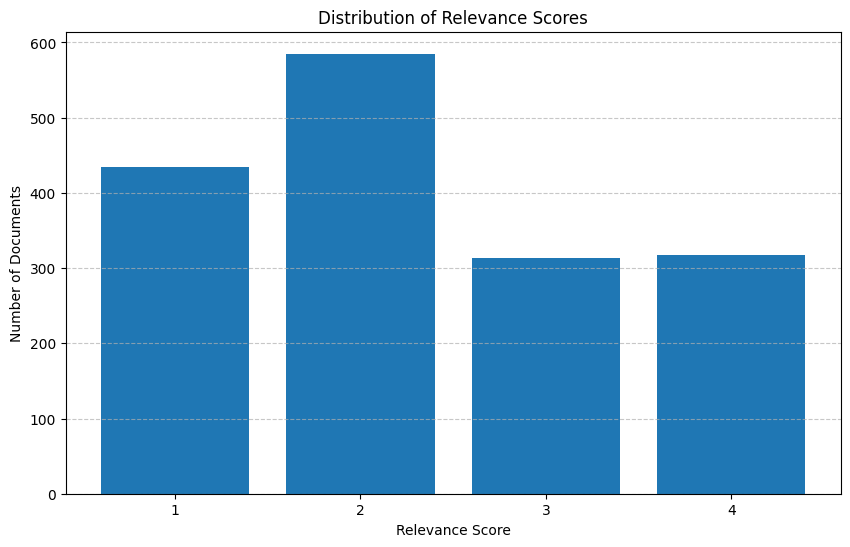

In [9]:
# 3. Display relevance score distribution
relevance_counts = query_df['relevance'].value_counts().sort_index()
print("\nRelevance score distribution:")
display(relevance_counts.to_frame().rename(columns={'relevance': 'count'}))

plt.figure(figsize=(10, 6))
plt.bar(relevance_counts.index.astype(str), relevance_counts.values)
plt.xlabel('Relevance Score')
plt.ylabel('Number of Documents')
plt.title('Distribution of Relevance Scores')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [10]:
# # Now proceed with cluster analysis as before
# print("\n=== Clustering Analysis ===")

# # 4. Basic cluster statistics
# cluster_sizes = cluster_mapping['cluster'].value_counts().sort_index()
# total_docs = len(cluster_mapping)
# num_clusters = cluster_mapping['cluster'].nunique()

# print(f"Total documents: {total_docs}")
# print(f"Number of clusters: {num_clusters}")
# print("\nCluster distribution:")
# display(cluster_sizes.to_frame().rename(columns={'cluster': 'count'}))
# print("\nCluster correspondence:")
# display(correspondence)

In [11]:
# # 5. Visualize cluster sizes
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# # Bar chart for exact values
# ax1.bar(cluster_sizes.index, cluster_sizes.values)
# ax1.set_xlabel('Cluster ID')
# ax1.set_ylabel('Number of documents')
# ax1.set_title('Document distribution across clusters')
# ax1.grid(axis="y", linestyle="--", alpha=0.7)

# # Histogram for distribution pattern
# # filtered_counts = cluster_sizes[cluster_sizes < 500]
# ax2.hist(cluster_sizes, bins=15, edgecolor='black', alpha=0.7)
# ax2.set_xlabel("Number of Documents per Cluster")
# ax2.set_ylabel("Frequency")
# ax2.set_title("Histogram of Documents per Cluster")
# ax2.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()


=== Clustering Analysis ===
Total documents: 6486
Number of clusters: 50

Cluster Size Statistics:


,count
count,50.000000
mean,129.720000
std,75.663066
min,20.000000
25%,65.250000
50%,114.000000
75%,176.750000
90%,240.000000
95%,272.850000
99%,309.930000



Cluster Size Distribution:


,Size Range,Number of Clusters,Percentage,Total Documents,% of Documents
0,1-10,0,0.0,0,0.000000
1,11-50,6,12.0,218,3.361085
2,51-100,15,30.0,1091,16.820845
3,101-500,29,58.0,5177,79.818070
4,501-1000,0,0.0,0,0.000000
5,1001+,0,0.0,0,0.000000



Top 5 Largest Clusters:


,Cluster ID,Size,% of Documents,Cumulative %
0,13,331,5.10,5.10
1,26,288,4.44,9.54
2,7,285,4.39,13.93
3,45,258,3.98,17.91
4,47,258,3.98,21.89



The top 5 clusters contain 1420 documents (21.89% of the total)

Correspondence for Top 5 Clusters:


,final_cluster,initial_cluster
7,7,11
13,13,20
26,26,34
45,45,67
47,47,71


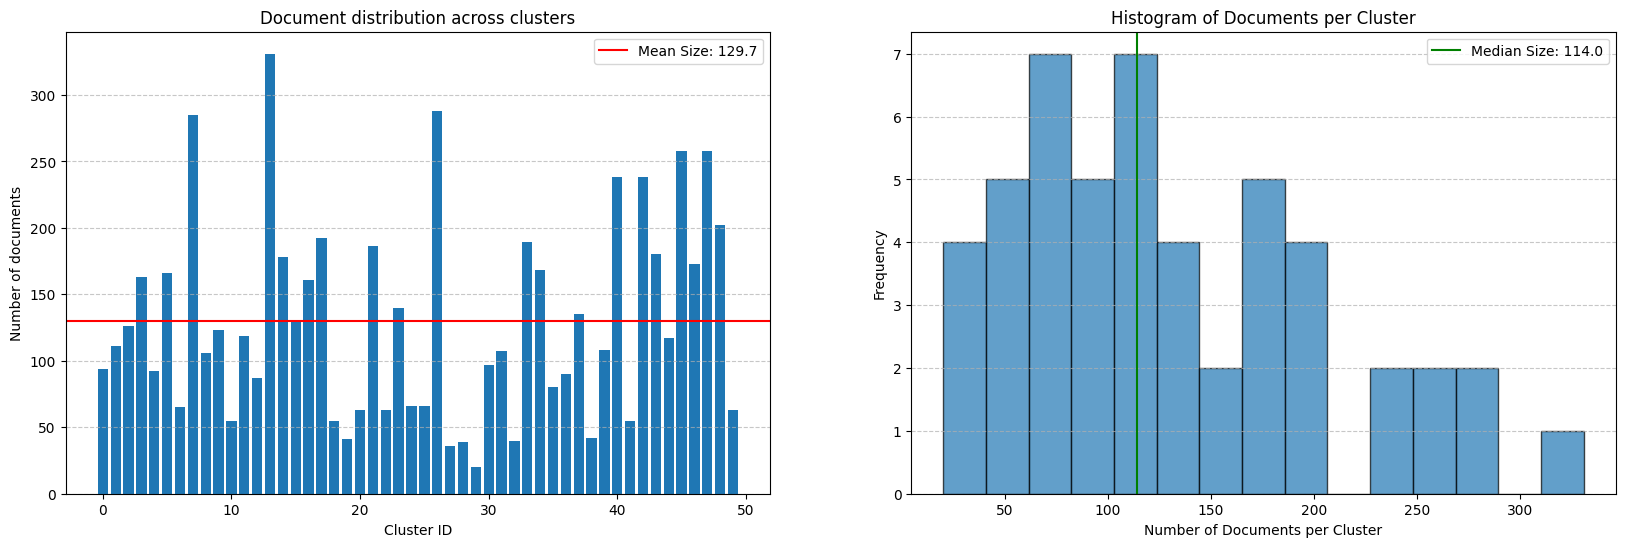

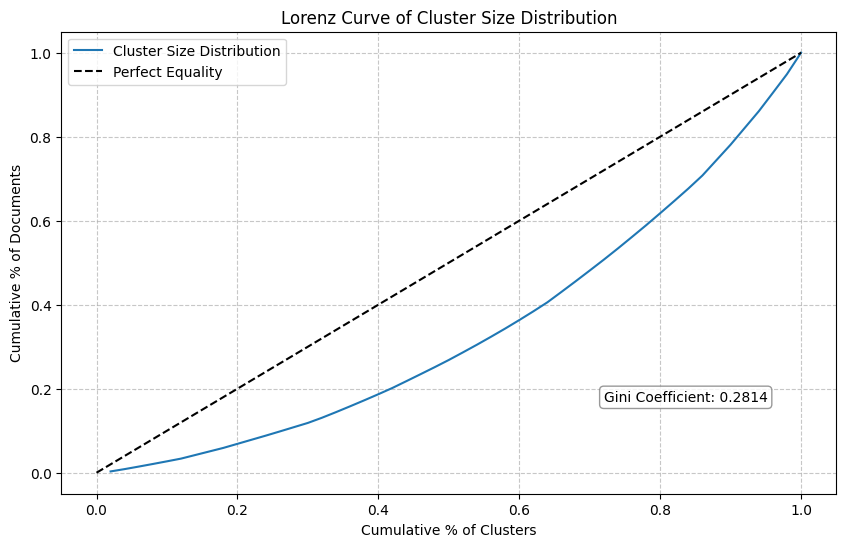

In [12]:
# Now proceed with cluster analysis as before
print("\n=== Clustering Analysis ===")

# 4. Basic cluster statistics
cluster_sizes = cluster_mapping['cluster'].value_counts().sort_index()
total_docs = len(cluster_mapping)
num_clusters = cluster_mapping['cluster'].nunique()

print(f"Total documents: {total_docs}")
print(f"Number of clusters: {num_clusters}")

# Calculate percentile statistics for cluster sizes
cluster_size_stats = cluster_sizes.describe(percentiles=[.25, .5, .75, .9, .95, .99])
print("\nCluster Size Statistics:")
display(cluster_size_stats.to_frame().rename(columns={0: 'Statistics'}))

# Show clusters by size categories
size_categories = [
    (1, 10), (11, 50), (51, 100), (101, 500), 
    (501, 1000), (1001, float('inf'))
]
cluster_size_distribution = {}
for low, high in size_categories:
    count = ((cluster_sizes >= low) & (cluster_sizes <= high)).sum()
    if high == float('inf'):
        range_label = f"{low}+"
    else:
        range_label = f"{low}-{high}"
    cluster_size_distribution[range_label] = count

print("\nCluster Size Distribution:")
size_dist_df = pd.DataFrame(list(cluster_size_distribution.items()), 
                            columns=['Size Range', 'Number of Clusters'])
size_dist_df['Percentage'] = size_dist_df['Number of Clusters'] / num_clusters * 100
size_dist_df['Total Documents'] = 0

# Calculate how many documents are in each size range
for i, (low, high) in enumerate(size_categories):
    docs_in_range = cluster_sizes[(cluster_sizes >= low) & (cluster_sizes <= high)].sum()
    size_dist_df.loc[i, 'Total Documents'] = docs_in_range

size_dist_df['% of Documents'] = size_dist_df['Total Documents'] / total_docs * 100
display(size_dist_df)

# Show top clusters and their dominance
top_n = 5
top_clusters = cluster_sizes.nlargest(top_n)
top_clusters_pct = (top_clusters / total_docs * 100).round(2)

print(f"\nTop {top_n} Largest Clusters:")
top_clusters_df = pd.DataFrame({
    'Cluster ID': top_clusters.index,
    'Size': top_clusters.values,
    '% of Documents': top_clusters_pct.values,
    'Cumulative %': top_clusters_pct.cumsum().values
})
display(top_clusters_df)

print(f"\nThe top {top_n} clusters contain {top_clusters.sum()} documents ({(top_clusters.sum()/total_docs*100):.2f}% of the total)")

# Show cluster correspondence for top clusters
print(f"\nCorrespondence for Top {top_n} Clusters:")
top_correspondence = correspondence[correspondence['final_cluster'].isin(top_clusters.index)]
display(top_correspondence)

# 5. Visualize cluster sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Bar chart for exact values
ax1.bar(cluster_sizes.index, cluster_sizes.values)
ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Number of documents')
ax1.set_title('Document distribution across clusters')
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Add a line for the mean size
ax1.axhline(y=cluster_sizes.mean(), color='r', linestyle='-', label=f'Mean Size: {cluster_sizes.mean():.1f}')
ax1.legend()

# Histogram for distribution pattern
ax2.hist(cluster_sizes, bins=15, edgecolor='black', alpha=0.7)
ax2.set_xlabel("Number of Documents per Cluster")
ax2.set_ylabel("Frequency")
ax2.set_title("Histogram of Documents per Cluster")
ax2.grid(axis="y", linestyle="--", alpha=0.7)

# Add a vertical line for the median size
ax2.axvline(x=cluster_sizes.median(), color='g', linestyle='-', label=f'Median Size: {cluster_sizes.median():.1f}')
ax2.legend()

plt.show()

# Generate a Lorenz curve to visualize cluster size inequality
cluster_sizes_sorted = cluster_sizes.sort_values()
cumulative_sizes = cluster_sizes_sorted.cumsum() / cluster_sizes_sorted.sum()
percentiles = np.arange(1, len(cluster_sizes_sorted) + 1) / len(cluster_sizes_sorted)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, cumulative_sizes, label='Cluster Size Distribution')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
plt.xlabel('Cumulative % of Clusters')
plt.ylabel('Cumulative % of Documents')
plt.title('Lorenz Curve of Cluster Size Distribution')
plt.grid(True, linestyle='--', alpha=0.7)

# Calculate and display Gini coefficient
gini = (np.trapz(np.arange(0, 1, 1/len(percentiles)), cumulative_sizes) * 2) - 1
plt.annotate(f'Gini Coefficient: {gini:.4f}', 
             xy=(0.7, 0.2), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.legend()
plt.show()

Note on the correspondence above: The significance is that both final clusters 0 and 24 (two of your largest clusters) came from the same initial cluster (149). This indicates the quantum refinement process split one large initial cluster into two separate final clusters. This splitting didn't improve performance, as both clusters remain very large and likely contain documents that should be distributed across more specialized clusters.RetryClaude can make mistakes. Please double-check responses.

In [13]:
# 6. Create mapping dictionary for quick lookups
cluster_mapping_dict = dict(zip(cluster_mapping['doc_id'], cluster_mapping['cluster']))

In [14]:
# 7. Analyze specific example query mentioned in logs
example_query_id = 1964316
example_query_data = query_df[query_df['query_id'] == example_query_id]
if not example_query_data.empty:
    relevant_docs = example_query_data[example_query_data['relevance'] > 0]['doc_id'].tolist()
    relevant_clusters = cluster_mapping[cluster_mapping['doc_id'].isin(relevant_docs)]['cluster']
    
    print(f"\n=== Example Query Analysis ===")
    print(f"Query {example_query_id} has {len(relevant_docs)} relevant documents")
    print(f"These documents are distributed across {relevant_clusters.nunique()} clusters")
    print("Cluster distribution of relevant docs:")
    display(relevant_clusters.value_counts().to_frame().rename(columns={'cluster': 'count'}))


=== Example Query Analysis ===
Query 1964316 has 33 relevant documents
These documents are distributed across 11 clusters
Cluster distribution of relevant docs:


,count
cluster,
15,10
26,9
9,5
46,2
18,1
5,1
0,1
14,1
20,1


In [15]:
# 8. Analyze query coverage across all queries
query_ids = query_df['query_id'].unique()
query_stats = []

for qid in query_ids:
    query_data = query_df[query_df['query_id'] == qid]
    relevant_docs = query_data[query_data['relevance'] > 0]['doc_id'].tolist()
    
    if len(relevant_docs) == 0:
        continue
    
    # Track which clusters contain relevant docs for this query
    clusters = []
    for doc_id in relevant_docs:
        if doc_id in cluster_mapping_dict:
            clusters.append(cluster_mapping_dict[doc_id])
    
    if len(clusters) > 0:
        # Calculate metrics
        unique_clusters = len(set(clusters))
        coverage = len(clusters) / len(relevant_docs)
        
        # Calculate cluster purity (% of docs in most common cluster)
        cluster_counts = Counter(clusters)
        if cluster_counts:
            max_cluster_count = max(cluster_counts.values())
            purity = max_cluster_count / len(clusters)
        else:
            purity = 0
        
        # Store metrics
        query_stats.append({
            'query_id': qid,
            'relevant_docs': len(relevant_docs),
            'docs_found': len(clusters),
            'coverage': coverage,
            'unique_clusters': unique_clusters,
            'purity': purity,
            'main_cluster': cluster_counts.most_common(1)[0][0] if cluster_counts else None
        })

# Convert to DataFrame for tabular display
query_stats_df = pd.DataFrame(query_stats)
print("\n=== Query Coverage Statistics ===")
print(f"Analyzed {len(query_stats_df)} queries with relevant documents")
print("\nSummary statistics:")
display(query_stats_df[['coverage', 'unique_clusters', 'purity']].describe())


=== Query Coverage Statistics ===
Analyzed 50 queries with relevant documents

Summary statistics:


,coverage,unique_clusters,purity
count,50.0,50.000000,50.000000
mean,1.0,13.160000,0.344825
std,0.0,4.107534,0.162553
min,1.0,6.000000,0.111111
25%,1.0,10.000000,0.250000
50%,1.0,13.000000,0.300164
75%,1.0,16.000000,0.393750
max,1.0,23.000000,0.800000


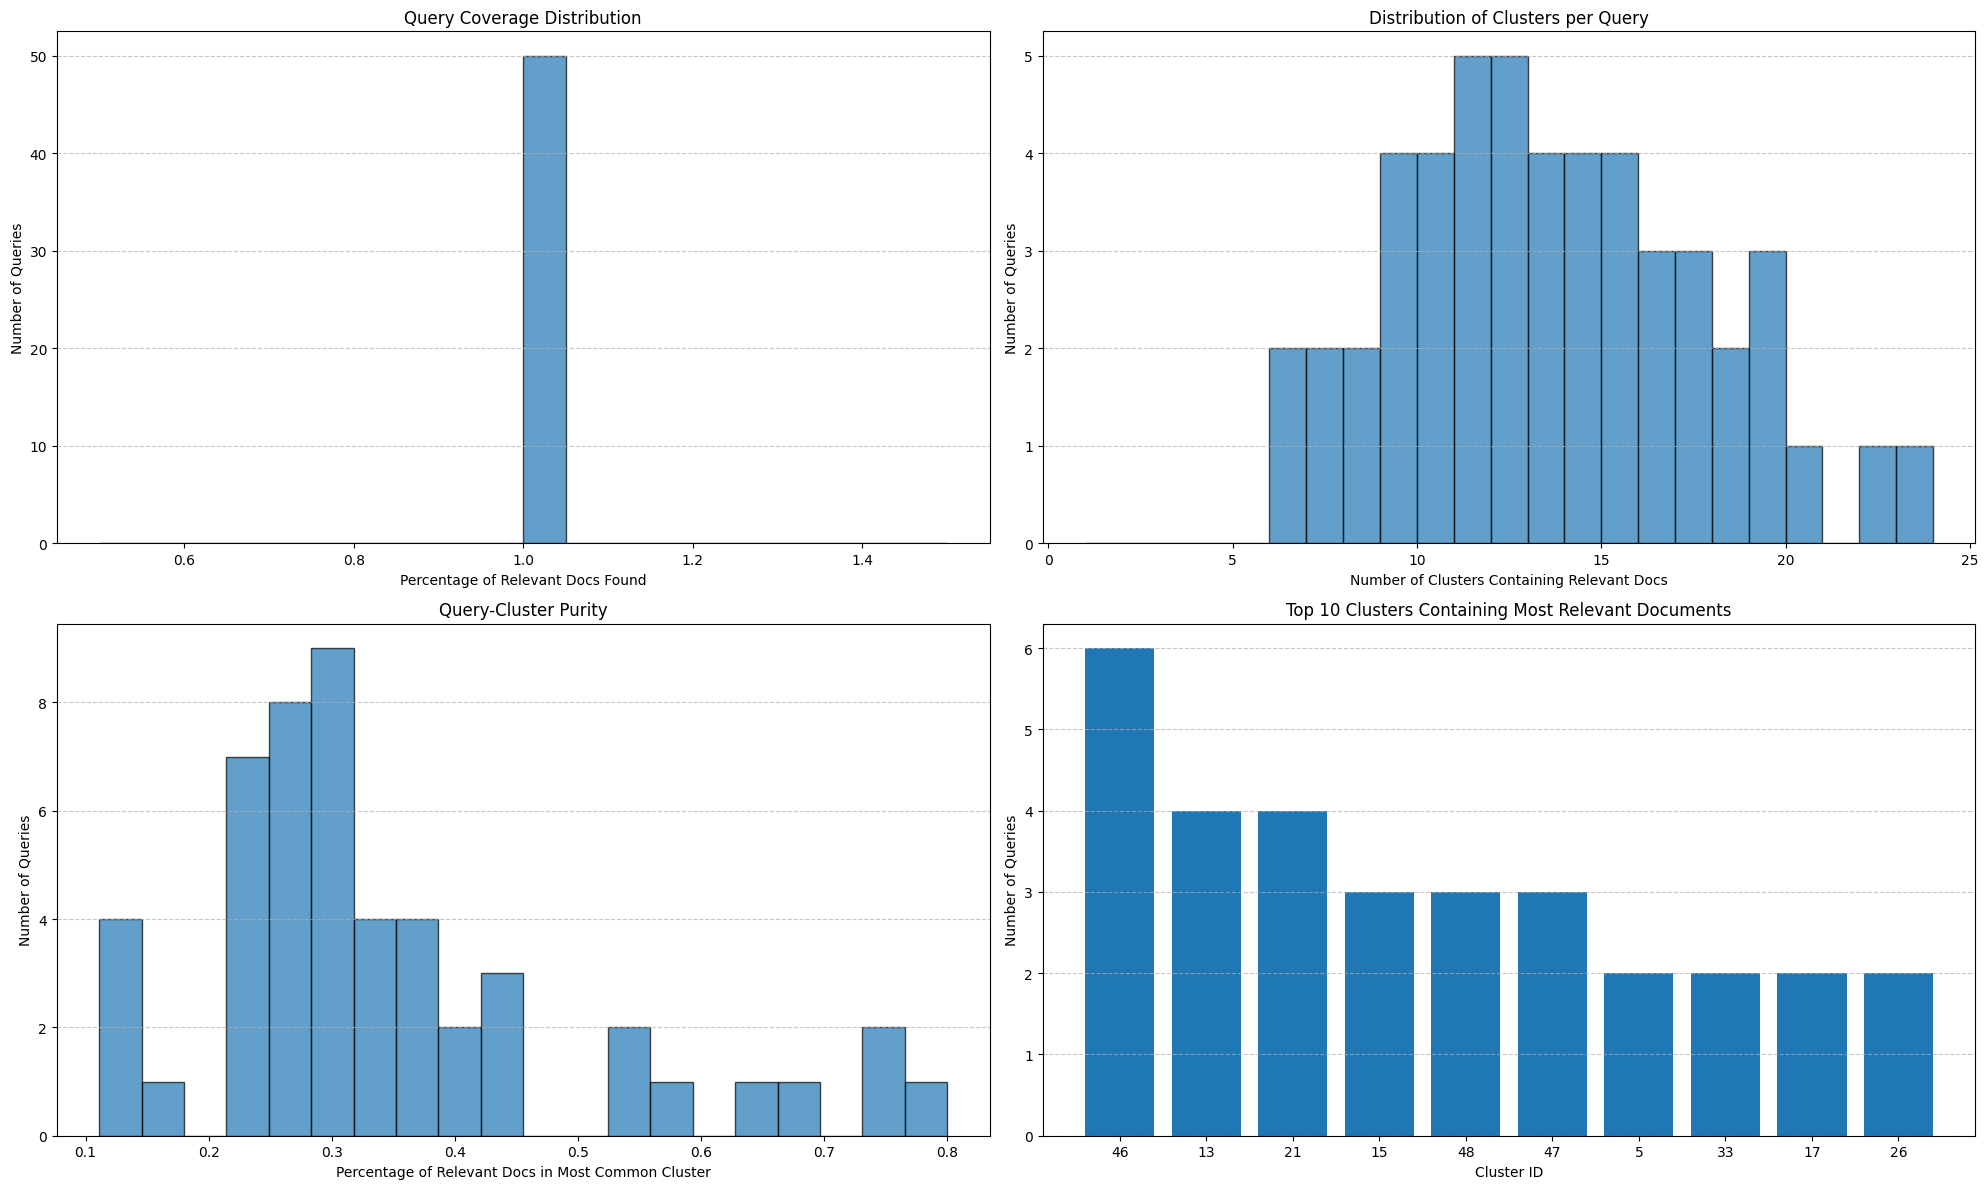

In [16]:
# 9. Visualize query coverage metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Coverage histogram
axes[0, 0].hist(query_stats_df['coverage'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel("Percentage of Relevant Docs Found")
axes[0, 0].set_ylabel("Number of Queries")
axes[0, 0].set_title("Query Coverage Distribution")
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

# Clusters per query histogram
axes[0, 1].hist(query_stats_df['unique_clusters'], bins=range(1, max(query_stats_df['unique_clusters']) + 2), 
                edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel("Number of Clusters Containing Relevant Docs")
axes[0, 1].set_ylabel("Number of Queries")
axes[0, 1].set_title("Distribution of Clusters per Query")
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

# Purity histogram
axes[1, 0].hist(query_stats_df['purity'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel("Percentage of Relevant Docs in Most Common Cluster")
axes[1, 0].set_ylabel("Number of Queries")
axes[1, 0].set_title("Query-Cluster Purity")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

# Top cluster distribution
main_cluster_counts = query_stats_df['main_cluster'].value_counts()
top_clusters = main_cluster_counts.nlargest(10)
axes[1, 1].bar(top_clusters.index.astype(str), top_clusters.values)
axes[1, 1].set_xlabel("Cluster ID")
axes[1, 1].set_ylabel("Number of Queries")
axes[1, 1].set_title("Top 10 Clusters Containing Most Relevant Documents")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# 10. Display the top and bottom queries by coverage/purity
print("\n=== Top 10 Queries by Purity ===")
display(query_stats_df.sort_values('purity', ascending=False).head(10)[['query_id', 'relevant_docs', 'coverage', 'unique_clusters', 'purity', 'main_cluster']])

print("\n=== Bottom 10 Queries by Purity ===")
display(query_stats_df.sort_values('purity', ascending=True).head(10)[['query_id', 'relevant_docs', 'coverage', 'unique_clusters', 'purity', 'main_cluster']])


=== Top 10 Queries by Purity ===


,query_id,relevant_docs,coverage,unique_clusters,purity,main_cluster
14,3396066,35,1.0,6,0.800000,11
41,1944018,49,1.0,11,0.755102,14
18,4185501,35,1.0,9,0.742857,47
32,2446614,34,1.0,9,0.676471,46
38,4372730,64,1.0,12,0.640625,45
17,103830,25,1.0,7,0.560000,21
27,2582920,27,1.0,9,0.555556,48
46,4365565,31,1.0,8,0.548387,13
37,1035857,36,1.0,11,0.444444,21
22,1199639,39,1.0,10,0.435897,13



=== Bottom 10 Queries by Purity ===


,query_id,relevant_docs,coverage,unique_clusters,purity,main_cluster
31,4448097,36,1.0,22,0.111111,9
23,4196421,24,1.0,18,0.125000,46
8,2382487,55,1.0,23,0.127273,26
12,4003223,35,1.0,19,0.142857,33
35,785823,30,1.0,19,0.166667,0
1,2418598,37,1.0,19,0.216216,3
36,2142044,23,1.0,14,0.217391,13
44,100653,32,1.0,13,0.218750,5
33,1017690,27,1.0,13,0.222222,46
42,3411123,38,1.0,20,0.236842,46


In [18]:
# Add this new section to investigate nDCG=0 issue
print("\n=== Investigation of nDCG Issues ===")

# Let's examine the specific queries mentioned in the output
problematic_queries = [1964316, 2418598, 1167882, 1880028, 2192891]

# Convert query embeddings to numpy arrays for similarity calculations
query_df['query_embeddings'] = query_df['query_embeddings'].apply(
    lambda x: np.fromstring(x[1:-1], dtype=float, sep=',') if isinstance(x, str) else np.array([])
)

# Function to analyze a query's retrieval issues
def analyze_query_ndcg_issue(query_id, cluster_id):
    print(f"\nAnalyzing Query {query_id} - Cluster {cluster_id}")
    
    # Get query data
    query_data = query_df[query_df['query_id'] == query_id]
    if len(query_data) == 0 or 'query_embeddings' not in query_data.columns:
        print("  Query data not found or missing embeddings")
        return
    
    query_embedding = query_data.iloc[0]['query_embeddings']
    if len(query_embedding) == 0:
        print("  Query embedding is empty")
        return
    
    # Get relevant documents
    relevant_docs = query_data[query_data['relevance'] > 0]['doc_id'].tolist()
    print(f"  Total relevant documents: {len(relevant_docs)}")
    
    # Get documents in the cluster
    cluster_docs = cluster_mapping[cluster_mapping['cluster'] == cluster_id]['doc_id'].tolist()
    print(f"  Documents in cluster {cluster_id}: {len(cluster_docs)}")
    
    # Find overlap
    relevant_in_cluster = set(relevant_docs).intersection(set(cluster_docs))
    print(f"  Relevant documents in cluster: {len(relevant_in_cluster)}")
    
    if len(relevant_in_cluster) == 0:
        print("  No relevant documents in this cluster - nDCG will be 0")
        return
    
    # Load document embeddings to check similarities
    train_df = pd.read_csv(docs_csv, converters={"doc_embeddings": lambda x: np.fromstring(x[1:-1], dtype=float, sep=',')})
    
    # Calculate relevance scores
    relevant_in_cluster_df = train_df[train_df['doc_id'].isin(relevant_in_cluster)]
    
    if len(relevant_in_cluster_df) == 0:
        print("  Couldn't find document embeddings for relevant docs in cluster")
        return
    
    # Calculate similarity to query
    query_embedding_norm = query_embedding / np.linalg.norm(query_embedding)
    
    similarity_scores = []
    for _, row in relevant_in_cluster_df.iterrows():
        doc_embedding = row['doc_embeddings']
        doc_embedding_norm = doc_embedding / np.linalg.norm(doc_embedding)
        similarity = np.dot(query_embedding_norm, doc_embedding_norm)
        relevance = query_data[query_data['doc_id'] == row['doc_id']]['relevance'].iloc[0]
        similarity_scores.append((row['doc_id'], similarity, relevance))
    
    # Sort by similarity
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("  Top relevant documents by similarity to query:")
    for i, (doc_id, sim, rel) in enumerate(similarity_scores[:10]):
        print(f"    Rank {i+1}: Doc {doc_id}, Similarity: {sim:.4f}, Relevance: {rel}")
    
    # Check if any relevant docs in top 10
    cluster_docs_df = train_df[train_df['doc_id'].isin(cluster_docs)]
    all_similarities = []
    
    for _, row in cluster_docs_df.iterrows():
        doc_embedding = row['doc_embeddings']
        doc_embedding_norm = doc_embedding / np.linalg.norm(doc_embedding)
        similarity = np.dot(query_embedding_norm, doc_embedding_norm)
        relevance = 0
        if row['doc_id'] in set(relevant_docs):
            relevance = query_data[query_data['doc_id'] == row['doc_id']]['relevance'].iloc[0]
        all_similarities.append((row['doc_id'], similarity, relevance))
    
    # Sort by similarity
    all_similarities.sort(key=lambda x: x[1], reverse=True)
    
    print("\n  Top 10 documents in cluster by similarity:")
    for i, (doc_id, sim, rel) in enumerate(all_similarities[:10]):
        relevance_str = f", Relevance: {rel}" if rel > 0 else ", Not Relevant"
        print(f"    Rank {i+1}: Doc {doc_id}, Similarity: {sim:.4f}{relevance_str}")
    
    # Count relevant in top 10
    top10_relevant = sum(1 for _, _, rel in all_similarities[:10] if rel > 0)
    print(f"\n  Relevant documents in top 10: {top10_relevant}")
    
    if top10_relevant == 0:
        print("  ISSUE FOUND: No relevant documents in top 10 rankings - nDCG@10 will be 0")
    else:
        ndcg_relevance = [rel for _, _, rel in all_similarities[:10]]
        print(f"  Relevance scores in top 10: {ndcg_relevance}")
        
        # Another reason for nDCG=0 could be that the calculation is incorrect in the pipeline
        print("  Note: Low nDCG despite having relevant docs could indicate ranking issues or calculation errors")


=== Investigation of nDCG Issues ===


In [19]:
# Analyze each problematic query
print("\nAnalyzing queries with zero nDCG despite finding relevant documents:")
for query_id in problematic_queries:
    # Find which cluster was assigned to this query
    example_query_data = query_df[query_df['query_id'] == query_id]
    if len(example_query_data) > 0:
        # The log shows cluster 26 was used for all the example queries
        analyze_query_ndcg_issue(query_id, 26)


Analyzing queries with zero nDCG despite finding relevant documents:

Analyzing Query 1964316 - Cluster 26
  Total relevant documents: 33
  Documents in cluster 26: 288
  Relevant documents in cluster: 9
  Top relevant documents by similarity to query:
    Rank 1: Doc 1964316_5, Similarity: 0.7556, Relevance: 4
    Rank 2: Doc 369616_4, Similarity: 0.7025, Relevance: 4
    Rank 3: Doc 3059341_5, Similarity: 0.7001, Relevance: 2
    Rank 4: Doc 1964316_4, Similarity: 0.6992, Relevance: 3
    Rank 5: Doc 1964316_0, Similarity: 0.6304, Relevance: 4
    Rank 6: Doc 1964316_2, Similarity: 0.4778, Relevance: 4
    Rank 7: Doc 2929011_0, Similarity: 0.4074, Relevance: 4
    Rank 8: Doc 3435824_3, Similarity: 0.3867, Relevance: 2
    Rank 9: Doc 4126855_1, Similarity: 0.3185, Relevance: 2

  Top 10 documents in cluster by similarity:
    Rank 1: Doc 1964316_5, Similarity: 0.7556, Relevance: 4
    Rank 2: Doc 369616_4, Similarity: 0.7025, Relevance: 4
    Rank 3: Doc 3059341_5, Similarity: 0.7

In [20]:
# Investigate issues with cluster 26 specifically
print("\n=== Analysis of Cluster 26 ===")
cluster_26_docs = cluster_mapping[cluster_mapping['cluster'] == 26]['doc_id'].tolist()
print(f"Number of documents in cluster 26: {len(cluster_26_docs)}")


=== Analysis of Cluster 26 ===
Number of documents in cluster 26: 288


In [21]:
# Find how many queries have relevant documents in cluster 26
queries_with_docs_in_26 = []
for qid in query_df['query_id'].unique():
    query_data = query_df[query_df['query_id'] == qid]
    relevant_docs = query_data[query_data['relevance'] > 0]['doc_id'].tolist()
    relevant_in_cluster = set(relevant_docs).intersection(set(cluster_26_docs))
    if len(relevant_in_cluster) > 0:
        pct_in_cluster = len(relevant_in_cluster) / len(relevant_docs) * 100
        queries_with_docs_in_26.append((qid, len(relevant_docs), len(relevant_in_cluster), pct_in_cluster))

print(f"Number of queries with relevant documents in cluster 26: {len(queries_with_docs_in_26)}")
queries_with_docs_in_26_df = pd.DataFrame(queries_with_docs_in_26, 
                                        columns=['query_id', 'total_relevant', 'relevant_in_cluster', 'percentage'])

Number of queries with relevant documents in cluster 26: 25


In [22]:
print("\nTop 10 queries by relevant docs in cluster 26:")
display(queries_with_docs_in_26_df.sort_values('relevant_in_cluster', ascending=False).head(10))


Top 10 queries by relevant docs in cluster 26:


,query_id,total_relevant,relevant_in_cluster,percentage
0,1964316,33,9,27.272727
3,1880028,31,9,29.032258
7,2382487,55,7,12.727273
5,949154,28,5,17.857143
11,1077370,26,4,15.384615
13,2838988,24,4,16.666667
9,4003223,35,4,11.428571
15,1971899,12,3,25.000000
1,2418598,37,3,8.108108
21,2814599,23,2,8.695652


In [23]:
# How much of the corpus is in cluster 26?
corpus_pct = len(cluster_26_docs) / len(cluster_mapping) * 100
print(f"\nCluster 26 contains {len(cluster_26_docs)} documents ({corpus_pct:.2f}% of corpus)")


Cluster 26 contains 288 documents (4.44% of corpus)


In [24]:
# Check if the retrieval function has an issue
print("\nPossible issues with the retrieval function:")
print("1. The retrieval may not be ranking documents within a cluster effectively")
print("2. The nDCG calculation might be discarding documents with zero relevance incorrectly")
print("3. Relevant documents might be in the cluster but not in the top 10 ranked results")
print("4. The similarity between query and document embeddings may not match relevance judgments")


Possible issues with the retrieval function:
1. The retrieval may not be ranking documents within a cluster effectively
2. The nDCG calculation might be discarding documents with zero relevance incorrectly
3. Relevant documents might be in the cluster but not in the top 10 ranked results
4. The similarity between query and document embeddings may not match relevance judgments
